In [1]:
!pip install catboost


Defaulting to user installation because normal site-packages is not writeable


### 1. Kütüphanelerin Yüklenmesi ve Veri Seti
Analiz için gerekli olan Pandas, Numpy ve görselleştirme araçları yüklenir. Modelleme için **Support Vector Classifier (SVC)** ve Gradient Boosting tabanlı **CatBoost** kütüphaneleri kullanılır.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)

from sklearn.svm import SVC
from catboost import CatBoostClassifier


In [3]:
df = pd.read_csv("googleplaystore.csv")

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (10841, 13)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


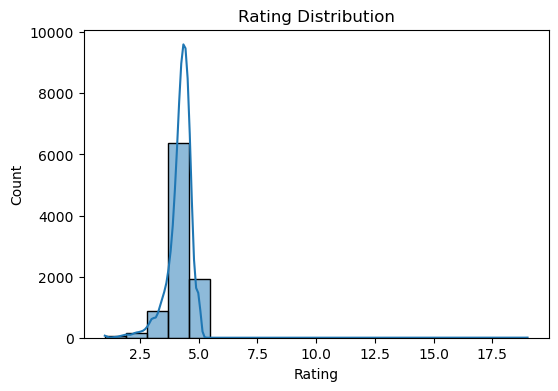

In [4]:
plt.figure(figsize=(6,4))
sns.histplot(df['Rating'], bins=20, kde=True)
plt.title("Rating Distribution")
plt.show()


In [5]:
df.isna().sum()


App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

### 2. Veri Ön İşleme ve Hedef Değişkenin Oluşturulması
Bu adımda ham veriler makine öğrenmesi modeline uygun hale getirilir:
* **Hedef Değişken (High_Rating):** `Rating` değeri 4.0 ve üzeri olanlar "1" (Başarılı), altındakiler "0" (Başarısız) olarak etiketlenir.
* **Temizleme:** `Reviews`, `Installs` ve `Price` sütunlarındaki sayısal olmayan karakterler ('+', '$', ',') temizlenir ve bu sütunlar sayısal veriye (numeric) dönüştürülür.

In [6]:
# Rating
df = df.dropna(subset=['Rating'])

# Target
df['High_Rating'] = (df['Rating'] >= 4.0).astype(int)

# Reviews
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

# Installs
df['Installs'] = df['Installs'].astype(str)
df['Installs'] = df['Installs'].str.replace('[+,]', '', regex=True)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

# Price
df['Price'] = df['Price'].astype(str)
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')


df = df.dropna(subset=['Reviews', 'Installs', 'Price'])
print(df[['Reviews','Installs','Price']].dtypes)


Reviews     float64
Installs    float64
Price       float64
dtype: object


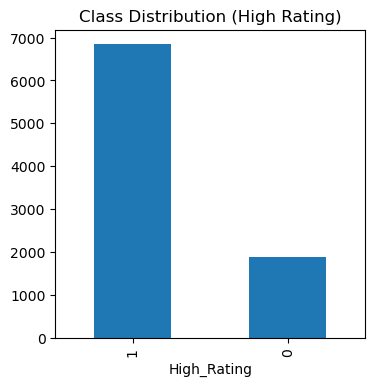

In [7]:
plt.figure(figsize=(4,4))
df['High_Rating'].value_counts().plot(kind='bar')
plt.title("Class Distribution (High Rating)")
plt.show()


### 3. Eğitim ve Test Verisinin Hazırlanması
* **Özellik Seçimi:** Modelde kullanılacak özellikler (`Reviews`, `Installs`, `Price`) belirlenir.
* **Veri Ayrımı:** Veri seti %80 Eğitim ve %20 Test olacak şekilde ayrılır.
* **Ölçeklendirme (StandardScaler):** SVC gibi uzaklık temelli algoritmalar verilerin ölçeğine duyarlıdır. Bu nedenle veriler, ortalaması 0 ve standart sapması 1 olacak şekilde standartlaştırılır.

In [8]:
features = ['Reviews', 'Installs', 'Price']
X = df[features]
y = df['High_Rating']


In [9]:
features = ['Reviews', 'Installs', 'Price']
X = df[features]
y = df['High_Rating']


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [11]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


### 4. Destek Vektör Makineleri (SVC) ile Modelleme
İlk olarak `RBF` (Radial Basis Function) çekirdeği kullanan bir SVC modeli eğitilir. Veri setindeki dengesizliği yönetmek için `class_weight='balanced'` parametresi kullanılarak azınlık sınıfına daha fazla ağırlık verilir.

In [12]:
svc = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    probability=True,
    class_weight='balanced',
    random_state=42
)

svc.fit(X_train_scaled, y_train)

y_pred_svc = svc.predict(X_test_scaled)
y_proba_svc = svc.predict_proba(X_test_scaled)[:,1]

print("SVC Results")
print(classification_report(y_test, y_pred_svc))
print("ROC AUC:", roc_auc_score(y_test, y_proba_svc))


SVC Results
              precision    recall  f1-score   support

           0       0.28      0.96      0.43       375
           1       0.97      0.31      0.47      1369

    accuracy                           0.45      1744
   macro avg       0.62      0.63      0.45      1744
weighted avg       0.82      0.45      0.46      1744

ROC AUC: 0.729581689797906


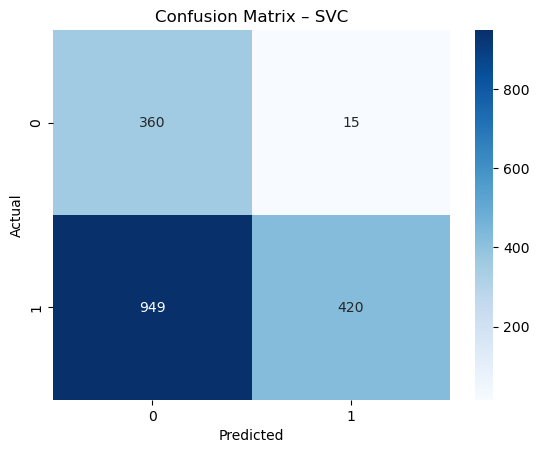

In [13]:
cm_svc = confusion_matrix(y_test, y_pred_svc)

sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – SVC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### 5. CatBoost Sınıflandırma Modeli
İkinci model olarak, kategorik verilerle de iyi çalışabilen ve yüksek performanslı bir Gradient Boosting algoritması olan **CatBoostClassifier** kullanılır. Model eğitilir ve test seti üzerindeki performansı ölçülür.

In [14]:
cat = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=0,
    random_state=42
)

cat.fit(X_train, y_train)

y_pred_cat = cat.predict(X_test)
y_proba_cat = cat.predict_proba(X_test)[:,1]

print("CatBoost Results")
print(classification_report(y_test, y_pred_cat))
print("ROC AUC:", roc_auc_score(y_test, y_proba_cat))


CatBoost Results
              precision    recall  f1-score   support

           0       0.41      0.09      0.15       375
           1       0.79      0.96      0.87      1369

    accuracy                           0.78      1744
   macro avg       0.60      0.53      0.51      1744
weighted avg       0.71      0.78      0.72      1744

ROC AUC: 0.7436464572680789


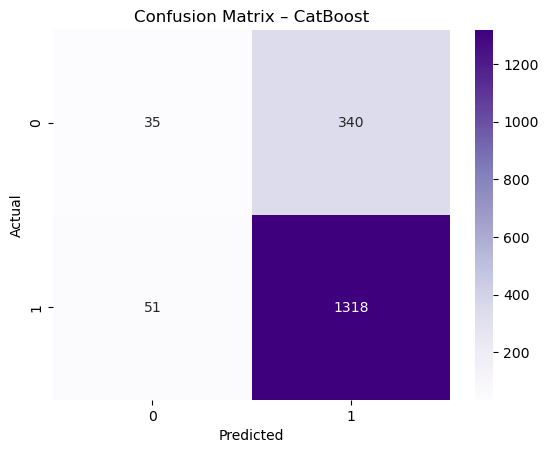

In [15]:
cm_cat = confusion_matrix(y_test, y_pred_cat)

sns.heatmap(cm_cat, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix – CatBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### 6. Modellerin Karşılaştırılması ve Sonuçlar
SVC ve CatBoost modellerinin başarıları kıyaslanır:
* **ROC Eğrisi:** İki modelin Doğru Pozitif ve Yanlış Pozitif oranları grafik üzerinde karşılaştırılır.
* **Sonuç Tablosu:** Precision, Recall, F1-Score ve ROC AUC metriklerini içeren bir özet tablo oluşturulur.

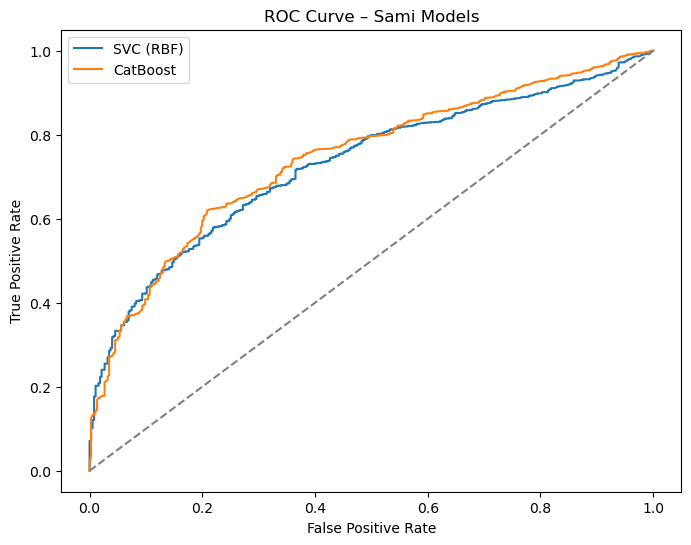

In [16]:
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_proba_svc)
fpr_cat, tpr_cat, _ = roc_curve(y_test, y_proba_cat)

plt.figure(figsize=(8,6))
plt.plot(fpr_svc, tpr_svc, label='SVC (RBF)')
plt.plot(fpr_cat, tpr_cat, label='CatBoost')
plt.plot([0,1], [0,1], '--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Sami Models")
plt.legend()
plt.show()


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score
from IPython.display import display
import pandas as pd

results_sami = pd.DataFrame({
    'Model': ['SVC (RBF)', 'CatBoost'],
    'Precision': [
        precision_score(y_test, y_pred_svc),
        precision_score(y_test, y_pred_cat)
    ],
    'Recall': [
        recall_score(y_test, y_pred_svc),
        recall_score(y_test, y_pred_cat)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_svc),
        f1_score(y_test, y_pred_cat)
    ],
    'ROC AUC': [
        roc_auc_score(y_test, y_proba_svc),
        roc_auc_score(y_test, y_proba_cat)
    ]
})

print("\nSami Model Comparison Table:")
print(results_sami.to_string(index=False))




Sami Model Comparison Table:
    Model  Precision   Recall  F1-Score  ROC AUC
SVC (RBF)   0.965517 0.306793  0.465632 0.729582
 CatBoost   0.794934 0.962747  0.870829 0.743646


In [18]:
print("\nTarget distribution (High Rating):")
print(df["High_Rating"].value_counts(normalize=True))



Target distribution (High Rating):
High_Rating
1    0.784723
0    0.215277
Name: proportion, dtype: float64
